# Understanding Different Transformer Architectures

One of the unique aspects of the Transformer architecture is that it has different variants. In this notebook, we will explore the different variants of the Transformer architecture and how they differ from each other.


# Seq2Seq


![Alt text](https://storage.googleapis.com/rg-ai-bootcamp/nlp/image-24.png)


Let's review our understanding in encoder-decoder architecture from RNN, as it will help our understanding how it's influenced in the Transformer architecture and how can we better understand later when we split the encoder and decoder into different parts.

## The essence of Encoder

Encoder is essentially the layer of understanding the input sequence, it's converting the input sequence into a vector that's meaningful, understand pretty well what's the input is about, what the writer intend to, and then giving it's undertanding by writing it into a vector.

## The essence of Decoder

Decoder is essentially the layer of generating the output sequence, it's converting the vector that was written by the encoder into a sequence of output.

## Encoder-Decoder

![Alt text](https://storage.googleapis.com/rg-ai-bootcamp/nlp/image-7.png)

When we classify the Transformer architecture into the encoder and decoder, we can see that from above images is that the encoder is the one on the left, and the decoder is the one on the right. In decoder we can see an additional component called the "Encoder decoder's Attention", which is the one that's responsible for bringing the encoder's and decoder's attention together.

## Encoder's attention

If we review our understanding of attention, it's basically: If you're currently looking at me, what other words in the sentence that you should be looking also? Because other words can hint you about the contexts that you should know about me.

Some weights of the model checkpoint at deepset/tinyroberta-squad2 were not used when initializing RobertaModel: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at deepset/tinyroberta-squad2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


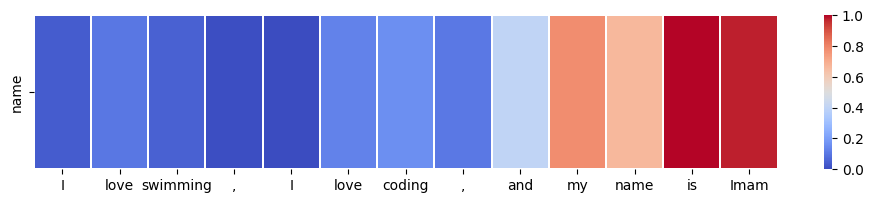

In [ ]:
import torch
from transformers import RobertaTokenizerFast, RobertaModel
import numpy as np

# Load pre-trained model (weights)
# Load pre-trained model (weights)
model = RobertaModel.from_pretrained('deepset/tinyroberta-squad2', output_attentions=True)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = RobertaTokenizerFast.from_pretrained('deepset/tinyroberta-squad2')

def visualize_self_attention_in_context(sentence_A, sentence_B, target_word):
    # Tokenize sentences
    inputs = tokenizer.encode_plus(sentence_A, sentence_B, return_tensors='pt', add_special_tokens=True)
    input_ids = inputs['input_ids'].to('cpu')

    # Model forward pass
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids)

    # Attention from all layers and all heads
    attentions_layers = np.array([layer[0, :, :, :].detach().numpy() for layer in outputs.attentions])

    # Mean attention across all heads for each layer
    attentions_heads_mean = attentions_layers.mean(axis=1)

    # Mean attention across all layers
    attentions_all_mean = attentions_heads_mean.mean(axis=0)

    token_list = tokenizer.convert_ids_to_tokens(input_ids[0])
    sep_index = token_list.index('</s>')

    # Focusing on self-attention within sentence_A (offsetting indices for </s> and <s> tags)
    attentions_all_mean_modified = attentions_all_mean[1:sep_index, 1:sep_index]

    # Normalize attention scores for each word
    attentions_all_mean_modified = (attentions_all_mean_modified - attentions_all_mean_modified.min(axis=1, keepdims=True)) / \
                                   (attentions_all_mean_modified.max(axis=1, keepdims=True) - attentions_all_mean_modified.min(axis=1, keepdims=True))

    token_list_A_modified = [t.lstrip('Ġ') for t in token_list[1:sep_index]]

    # Extract index of the target word
    try:
        target_index = token_list_A_modified.index(target_word)
    except ValueError:
        print(f"Target word '{target_word}' not found. Please ensure it is part of sentence_A.")
        return

    # Selecting attention weights for the target word
    target_word_attentions = attentions_all_mean_modified[target_index, :]

    # The code below visualizes attention distribution using seaborn as a heat map.
    plt.figure(figsize=(12, 2))
    sns.heatmap(np.expand_dims(target_word_attentions, axis=0),
                xticklabels=token_list_A_modified,
                yticklabels=[target_word],
                linewidths=0.1,
                cmap='coolwarm')
    plt.show()

# Usage
sentence_A = "I love swimming, I love coding, and my name is Imam"
sentence_B = "what's my name?"
target_word = "name"
visualize_self_attention_in_context(sentence_A, sentence_B, target_word)

As you can see above, when we're trying to check the attention of the word "name", we can see that we're being hinted at the word "my", "is", and "Imam". We can see that if we want to get the whole context of the word "name", these words are basically the ones that we should be looking at.

- "my" is the one that's hinting that the word "name" in the sentence is referring to the speaker, not any third person.
- "is" is the one that's hinting that the word "name" is referring to singular, not plural, this hint can be predicted from the word "my" as well.
- "Imam" is the one that's hinting that the word "name" is referring to the name "Imam", not any other name.

So basically the encoder layer is the one that's responsible to create this relationship between the words in the sentence, that later we'll pass to the decoder layer.


## Encoder encode every word at the same time

One thing to note is that in the encoder layer, we're encoding every word at the same time, so when we use the same example:

> I love swimming, I love coding, and my name is Imam

We're encoding the word "I" at the same time as the word "love", and the word "love" at the same time as the word "swimming", and so on. This is different from the RNN architecture, where we're encoding the word "I" first, then the word "love", and so on. This is one of the reason why the Transformer architecture is faster than the RNN architecture, because we're encoding every word at the same time, enabling us to parallelize the computation.

## Decoder's regressive property

The difference between the encoder and decoder is that the decoder is regressive, meaning that it's generating the output sequence one word at a time, from left to right. It's much like the RNN architecture, where we're generating the output sequence one word at a time, the last word will be the input for the next word.

## Decoder's attention

Decoder's attention follow the regressive property, meaning that attention scoring are generated from left to right. The idea of the decoder's attention is simple, based on what we've generated so far, what other words in the output sequence that might give hint to the next word that we're going to generate?

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small", output_attentions=True)

Tokenized word list:
['Ich', 'liebe', 'Schwimm', 'en', ',', '', 'ich', 'liebe', 'Cod', 'ierung', ',', 'und', 'mein', 'Name', 'ist']


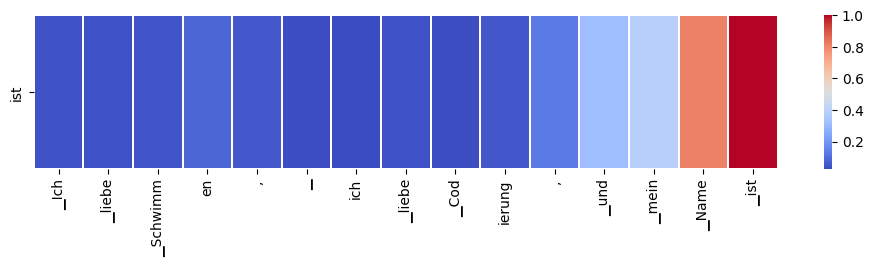

In [ ]:
def visualize_self_attention_in_context(english_sentence, german_translation_part, target_word):
    # Encode input and target sentences
    input_ids = tokenizer.encode("translate English to German: "+english_sentence, return_tensors='pt')
    decoder_input_ids = tokenizer.encode(german_translation_part, return_tensors='pt')

    # Model forward pass
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)

    # Attention from all layers and all heads
    attentions_layers = np.array([layer[0, :, :, :].detach().numpy() for layer in outputs.decoder_attentions])

    # Mean attention across all heads for each layer
    attentions_heads_mean = attentions_layers.mean(axis=1)

    # Mean attention across all layers
    attentions_all_mean = attentions_heads_mean.mean(axis=0)

    token_list = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

    # Normalize attention scores for each word
    attentions_all_mean = (attentions_all_mean - attentions_all_mean.min(axis=1, keepdims=True)) / \
                          (attentions_all_mean.max(axis=1, keepdims=True) - attentions_all_mean.min(axis=1, keepdims=True))

    # Strip the special characters added by the tokenizer
    token_list = [t.lstrip('Ġ') for t in token_list]

# Exclude </s> from the encoder tokens and attentions
    if '</s>' in token_list:
        end_index = token_list.index('</s>')
        token_list = token_list[:end_index]
        attentions_all_mean = attentions_all_mean[:, :end_index]

    # Find all indices of the target word
    target_indices = [i for i, token in enumerate(token_list) if target_word in token]

    # Ensure there's at least one occurrence of the target word
    if not target_indices:
        print(f"Target word '{target_word}' not found. Please ensure it is part of german_translation_part.")
        return

    # Selecting attention weights for the target word
    target_word_attentions = np.mean([attentions_all_mean[i, :] for i in target_indices], axis=0)

    print("Tokenized word list:")
    print([t.replace('▁', '') for t in token_list])

    # The code below visualizes attention distribution using seaborn as a heat map.
    plt.figure(figsize=(12, 2))
    sns.heatmap(np.expand_dims(target_word_attentions, axis=0),
                xticklabels=[t.rstrip('_') for t in token_list],
                yticklabels=[target_word],
                linewidths=0.1,
                cmap='coolwarm')
    plt.show()

# Usage
english_sentence = "I love swimming, I love coding, and my name is Imam"
german_translation_part = "Ich liebe Schwimmen, ich liebe Codierung, und mein Name ist"
target_word = "ist"
visualize_self_attention_in_context(english_sentence, german_translation_part, target_word)

As you can see above this sentence:

> I love swimming, I love coding, and my name is Imam

Is already translated into this sentence:

> Ich liebe Schwimmen, ich liebe Codierung, und mein Name ist

But we're still missing one last translation, the name "Imam". So above chart you can see that the model giving hint that the next word should be highly related to "Name", "ist", but the "mein", and "und" might not be that needed, but can still give you hint, so it's lower in score.

So basically the decoder attention is the one that's responsible to give hints of what might be needed to generate the next word in the output sequence.

# Encoder-decoder attention

Encoder-decoder attention purpose is aligning the encoder's and decoder's attention together, so we can get hints what the output should be. Remember again:

- Encoder has all words relationship on the input encoded, it's doing it all at the same time.
- Then decoder is generating the output sequence one word at a time, first it will go through the decoder's attention, then it will go through this encoder-decoder attention

So decoder has basically know what kind of the word should be in the next word, and then encoder-decoder attention will help to check from the encoder's attention, what word should be next, with hints given by the decoder's attention.

Tokenized word list:
['Ich', 'liebe', 'Schwimm', 'en', ',', '', 'ich', 'liebe', 'Cod', 'ierung', ',', 'und', 'mein', '</s>']


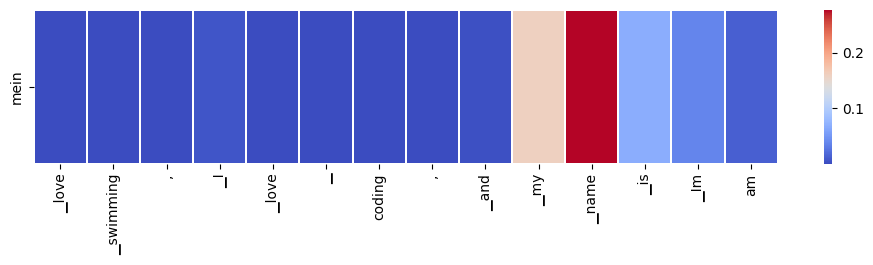

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import numpy as np

# Load pre-trained model (weights)
model = AutoModelForSeq2SeqLM.from_pretrained('t5-small', output_attentions=True)
# Load pre-trained model tokenizer (vocabulary)
tokenizer = AutoTokenizer.from_pretrained('t5-small')

def visualize_cross_attention_in_context(english_sentence, german_translation_part, target_word):
    # Encode input and target sentences
    input_text = "translate English to German: " + english_sentence
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    decoder_input_ids = tokenizer.encode(german_translation_part, return_tensors='pt')

    # Model forward pass
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids)

    # Cross-attention from all layers and all heads
    cross_attentions_layers = np.array([layer[0, :, :, :].detach().numpy() for layer in outputs.cross_attentions])

    # Mean cross-attention across all heads for each layer
    cross_attentions_heads_mean = cross_attentions_layers.mean(axis=1)

    # Mean cross-attention across all layers
    cross_attentions_all_mean = cross_attentions_heads_mean.mean(axis=0)

    encoder_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    decoder_tokens = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

    task_prefix_token_count = len(tokenizer.encode("translate English to German: ", return_tensors='pt')[0])
    # Reduce tokens and attentions by the number of tokens in the task prefix
    encoder_tokens = encoder_tokens[task_prefix_token_count:]
    cross_attentions_all_mean = cross_attentions_all_mean[:, task_prefix_token_count:]

    # Exclude </s> from the encoder tokens and attentions
    if '</s>' in encoder_tokens:
        end_index = encoder_tokens.index('</s>')
        encoder_tokens = encoder_tokens[:end_index]
        cross_attentions_all_mean = cross_attentions_all_mean[:, :end_index]

    # Find all indices of the target word in the German sentence
    target_indices = [i for i, token in enumerate(decoder_tokens) if target_word in token]

    if not target_indices:
        print(f"Target word '{target_word}' not found. Please make sure it is part of german_translation_part.")
        return

    # Selecting attention weights for the target word
    target_word_attentions = np.mean([cross_attentions_all_mean[i, :] for i in target_indices], axis=0)

    print("Tokenized word list:")
    print([t.replace('▁', '') for t in decoder_tokens])

    # Visualize cross-attention distribution using seaborn as a heat map
    plt.figure(figsize=(12, 2))
    sns.heatmap(np.expand_dims(target_word_attentions, axis=0),
                xticklabels=encoder_tokens,
                yticklabels=[target_word],
                linewidths=0.1,
                cmap='coolwarm')
    plt.show()

# Usage
english_sentence = "I love swimming, I love coding, and my name is Imam"
german_translation_part = "Ich liebe Schwimmen, ich liebe Codierung, und mein"
target_word = "mein"
visualize_cross_attention_in_context(english_sentence, german_translation_part, target_word)

> Ich liebe Schwimmen, ich liebe Codierung, und mein

As you can see above we just translated until "mein", and on above chart we can see that the decoder's attention is giving hint that the next word should be highly related to the English word "name", and "my".

# Encoder Only Architecture

As we already told above, the encoder is the one that's responsible to understand the input sequence. This layer is the one who manage to create relation on the input, and in effect, the layer who really understand the input sequence is this layer.

Most of the time if we're using this encoder only architecture, we're using it for task that highly need on understanding the input sequence, understand the relation between the words in the input sequence. Some example of the task that we can use this encoder only architecture is:

- Sentiment analysis
- Text classification
- POS tagging

# Decoder Only Architecture

The decoder only is more tricky to understand. This layer is mostly used in a text generation task, where we're generating the output sequence one word at a time. This layer basically has no way to "understand" the input sequence, and it's only relying on the decoder's attention to give hints on what the next word should be.

Sentence tokenized:
['After', 'Ġseveral', 'Ġmeeting', 'Ġwith', 'Ġthe', 'Ġclient', ',', 'Ġthe', 'Ġteam', 'Ġfinally', 'Ġdecided', 'Ġto', 'Ġaccept', 'Ġthe']


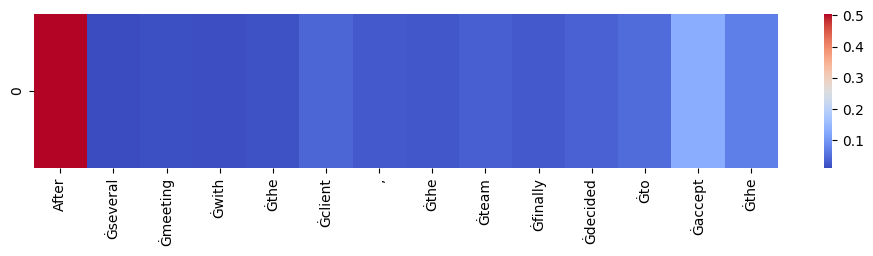

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2Tokenizer
import numpy as np

# Load pre-trained model (weights) & tokenizer
model = GPT2Model.from_pretrained('gpt2', output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

def visualize_self_attention_in_context(sentence):
    # Model forward pass
    model.eval()
    input_ids = tokenizer.encode(sentence, return_tensors='pt')

    with torch.no_grad():
        outputs = model(input_ids=input_ids)

    # Extract the attention values
    attentions_layers = np.array([layer[0, :, :, :].detach().numpy() for layer in outputs.attentions])

    # Compute the mean attention values across all heads for each layer
    attentions_heads_mean = attentions_layers.mean(axis=1)

    # Compute the mean attention values across all layers
    attentions_all_mean = attentions_heads_mean.mean(axis=0)

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Compute attention values for the last token (the latest prediction)
    attention_for_last_token = attentions_all_mean[-1, :]

    # Print out the tokens
    print("Sentence tokenized:")
    print(tokens)

    # Visualize using seaborn
    plt.figure(figsize=(12, 2))
    sns.heatmap(np.expand_dims(attention_for_last_token, axis=0), xticklabels=tokens, cmap='coolwarm')
    plt.show()


# Usage
sentence = "After several meeting with the client, the team finally decided to accept the"
visualize_self_attention_in_context(sentence)

On above example we see the visualization of the attention score of above GPT-2 model that it think will help the later fully connected layer to generate the next word. For GPT-2, for some reason it gives a hight attention score to the word "After" or any word that become the first word of the input. It's likely to make sure the model later understand the need to know the first word by default before caring any other words.

Let's try to remove the first word just for the sake of understanding what other words will be given high attention score:

Sentence tokenized:
['Ġseveral', 'Ġhours', 'Ġof', 'Ġdiscussion', 'Ġwith', 'Ġthe', 'Ġclient', ',', 'Ġthe', 'Ġteam', 'Ġfinally', 'Ġdecided', 'Ġto', 'Ġaccept', 'Ġthe']


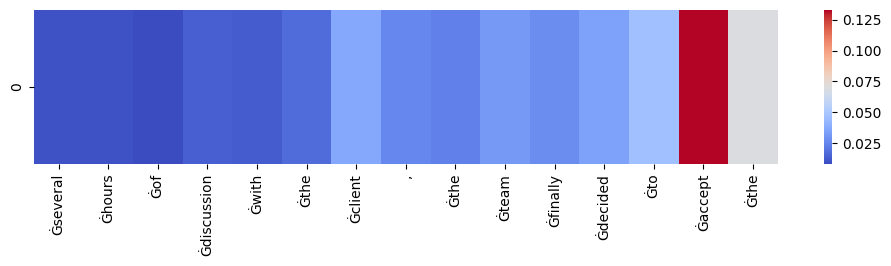

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2Tokenizer
import numpy as np

# Load pre-trained model (weights) & tokenizer
model = GPT2Model.from_pretrained('gpt2', output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

def visualize_self_attention_in_context(sentence):
    # Model forward pass
    model.eval()
    input_ids = tokenizer.encode(sentence, return_tensors='pt')

    with torch.no_grad():
        outputs = model(input_ids=input_ids)

    # Extract the attention values
    attentions_layers = np.array([layer[0, :, :, :].detach().numpy() for layer in outputs.attentions])

    # Compute the mean attention values across all heads for each layer
    attentions_heads_mean = attentions_layers.mean(axis=1)

    # Compute the mean attention values across all layers
    attentions_all_mean = attentions_heads_mean.mean(axis=0)

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Compute attention values for the last token (the latest prediction)
    attention_for_last_token = attentions_all_mean[-1, :]

    # Remove the attention to the first word and its corresponding token
    attention_for_last_token = attention_for_last_token[1:]
    tokens = tokens[1:]

    # Print out the tokens
    print("Sentence tokenized:")
    print(tokens)

    # Visualize using seaborn
    plt.figure(figsize=(12, 2))
    sns.heatmap(np.expand_dims(attention_for_last_token, axis=0), xticklabels=tokens, cmap='coolwarm')
    plt.show()


# Usage
sentence = "After several hours of discussion with the client, the team finally decided to accept the"
visualize_self_attention_in_context(sentence)

We'll see that the word "accept", "the", "to", and "client" are given high attention score. So we can see that just by using this, without having the need of "understanding" the input sequence (encoder), we might still be able to generate a good output sequence.

Like what's told, this decoder only architecture is mostly used in text generation task, where we're generating the output without having the need to understand the input sequence.

But in reality using something like GPT-3, there is a realization that we can still use this decoder only architecture to do some task classification or other task that seemingly need to understand the input sequence, as long as we're using a big enough model, and the task is prepared in a structure of text generation task.

Even though technically using decoder-only architecture, the score might not be as good as using architecture that's using encoder, or even if it comes close it can be highly expensive to train or use the model.

## Additional Materials

Youtube Videos
- [Coding a Transformer from scratch on PyTorch, with full explanation, training and inference.](https://www.youtube.com/watch?v=ISNdQcPhsts)
- [Illustrated Guide to Transformers Neural Network: A step by step explanation](https://www.youtube.com/watch?v=4Bdc55j80l8)

Paper
- [Attention is all you need](https://arxiv.org/abs/1706.03762)
- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [Language Models are Few-Shot Learners, Paper GPT-3](https://arxiv.org/abs/2005.14165)

Excalidraw
- [Excalidraw Link](https://excalidraw.com/#room=555d1bd0ae417beed7e2,h4FbRw56K9ACqgOukHN-LQ)
